# 🎓 Real/Fake Detection Model Eğitimi

Bu notebook'u kopyalayarak benzer eğitimler yapabilirsiniz.

REAL-FAKE AYRIMI

## 1️⃣ Setup

In [34]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from utils import *

# AYARLAR
NOTEBOOK_NAME = "real_fake_detection"
DATA_DIR = r"C:\AI_DATA\SEMI_TRUTHS_extracted"
CLASS_NAMES = ["real", "fake"]

BATCH_SIZE = 8
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
VAL_SPLIT = 0.2

# Setup
device = setup_device()
folders = create_training_folder(NOTEBOOK_NAME)

print(f"Notebook: {NOTEBOOK_NAME}")
print(f"Veri: {DATA_DIR}")
print(f"Sınıflar: {CLASS_NAMES}")

# ⭐ YENİ: Versiyon sistemi
version = 1
checkpoint_base_path = os.path.join(folders['models'], 'latest_checkpoint.pt')

# Önceki eğitimler varsa versiyonu arttır
if os.path.exists(checkpoint_base_path):
    existing_versions = [d for d in os.listdir(folders['data']) if d.startswith('v')]
    if existing_versions:
        version = max([int(d[1:]) for d in existing_versions if d[1:].isdigit()]) + 1

# Versiyonlu klasörler oluştur
version_folder = f"v{version}"
version_data_dir = os.path.join(folders['data'], version_folder)
version_plots_dir = os.path.join(folders['plots'], version_folder)

os.makedirs(version_data_dir, exist_ok=True)
os.makedirs(version_plots_dir, exist_ok=True)

print(f"\n📦 Versiyon {version} oluşturuldu:")
print(f"   Data: {version_data_dir}")
print(f"   Plots: {version_plots_dir}")

✅ GPU kullanılıyor: NVIDIA GeForce RTX 4060 Laptop GPU
✅ Klasör yapısı oluşturuldu: eğitim_sonuçları\real_fake_detection
Notebook: real_fake_detection
Veri: C:\AI_DATA\SEMI_TRUTHS_extracted
Sınıflar: ['real', 'fake']

📦 Versiyon 4 oluşturuldu:
   Data: eğitim_sonuçları\real_fake_detection\veriler\v4
   Plots: eğitim_sonuçları\real_fake_detection\görseller\v4


## 2️⃣ Veri Yükleme

In [20]:
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms
from PIL import Image
from collections import Counter
import random

class RealFakeDataset(Dataset):
    """Real/Fake resim dataseti
    
    Klasör yapısı:
    DATA_DIR/
    ├── original/images/     (REAL resimler)
    └── inpainting/          (FAKE resimler)
    """
    
    def __init__(self, data_dir, transform=None):
        self.data = []
        self.transform = transform
        
        # Real resimler (label=0)
        real_dir = os.path.join(data_dir, 'original', 'images')
        if os.path.exists(real_dir):
            for root, dirs, files in os.walk(real_dir):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        self.data.append((os.path.join(root, file), 0))
        
        # Fake resimler (label=1)
        fake_dir = os.path.join(data_dir, 'inpainting')
        if os.path.exists(fake_dir):
            for root, dirs, files in os.walk(fake_dir):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        self.data.append((os.path.join(root, file), 1))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Hata: {image_path}")
            return None, None
        return image, label

# Transform'lar
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ⭐ YENİ: Stratified sampling
print("\n📋 STRATIFIED SAMPLING")
print("="*70)

# Tam dataseti yükle
full_dataset = RealFakeDataset(DATA_DIR, transform=train_transform)
print(f"✅ Tam Dataset: {len(full_dataset)} görsel")

labels = [label for _, label in full_dataset.data]
label_counts = Counter(labels)
print(f"   Real: {label_counts[0]:,}")
print(f"   Fake: {label_counts[1]:,}")

# ⭐ STRATIFIED: Real ve Fake'i eşit hale getir
print(f"\n📊 Stratified sampling yapılıyor...")

real_indices = [i for i, (_, label) in enumerate(full_dataset.data) if label == 0]
fake_indices = [i for i, (_, label) in enumerate(full_dataset.data) if label == 1]

print(f"   Real indeksleri: {len(real_indices):,}")
print(f"   Fake indeksleri: {len(fake_indices):,}")

# ⭐ Real ve Fake'i eşit sayıda al
min_count = min(len(real_indices), len(fake_indices))
random.seed(42)
real_subset = random.sample(real_indices, min_count)
fake_subset = random.sample(fake_indices, min_count)

# Birleştir
subset_indices = real_subset + fake_subset
random.shuffle(subset_indices)

print(f"\n✅ Seçilen örnekler:")
print(f"   Real: {len(real_subset):,}")
print(f"   Fake: {len(fake_subset):,}")
print(f"   TOPLAM: {len(subset_indices):,}")

# Subset dataset oluştur
subset_dataset = Subset(full_dataset, subset_indices)

# Train/Val split
train_size = int(len(subset_dataset) * (1 - VAL_SPLIT))
val_size = len(subset_dataset) - train_size
train_dataset, val_dataset = random_split(subset_dataset, [train_size, val_size])

print(f"\n✅ Train/Val split:")
print(f"   Train: {len(train_dataset):,}")
print(f"   Val: {len(val_dataset):,}")

# ⭐ FIX: Subset içindeki indeksleri tam dataset indekslerine çevir
train_full_indices = [subset_indices[i] for i in train_dataset.indices]
val_full_indices = [subset_indices[i] for i in val_dataset.indices]

train_labels = [full_dataset.data[i][1] for i in train_full_indices]
val_labels = [full_dataset.data[i][1] for i in val_full_indices]

train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

print(f"\n📊 Train sınıf dağılımı:")
print(f"   Real: {train_counts[0]:,}")
print(f"   Fake: {train_counts[1]:,}")

print(f"\n📊 Val sınıf dağılımı:")
print(f"   Real: {val_counts[0]:,}")
print(f"   Fake: {val_counts[1]:,}")

# ⭐ YENİ: Custom dataset wrapper (val_transform uygulamak için)
class SubsetDatasetWithTransform(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        image_path, label = self.dataset.data[actual_idx]
        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            return None, None
        return image, label

# Val dataset'i yeniden oluştur (val_transform ile)
val_dataset = SubsetDatasetWithTransform(full_dataset, val_full_indices, transform=val_transform)

print(f"\n✅ Dataset hazır!")


📋 STRATIFIED SAMPLING
✅ Tam Dataset: 160068 görsel
   Real: 22,963
   Fake: 137,105

📊 Stratified sampling yapılıyor...
   Real indeksleri: 22,963
   Fake indeksleri: 137,105

✅ Seçilen örnekler:
   Real: 22,963
   Fake: 22,963
   TOPLAM: 45,926

✅ Train/Val split:
   Train: 36,740
   Val: 9,186

📊 Train sınıf dağılımı:
   Real: 18,338
   Fake: 18,402

📊 Val sınıf dağılımı:
   Real: 4,625
   Fake: 4,561

✅ Dataset hazır!


In [21]:
# ⭐ YENİ: Class weights hesapla
from collections import Counter

# Train ve val labellerini birleştir
all_labels_list = train_labels + val_labels
label_counts = Counter(all_labels_list)

print(f"\n📊 Sınıf dağılımı (toplam):")
print(f"   Real: {label_counts[0]:,}")
print(f"   Fake: {label_counts[1]:,}")

# Weights hesapla (inverse frequency)
total = len(all_labels_list)
weight_real = total / (2 * label_counts[0])
weight_fake = total / (2 * label_counts[1])

class_weights = torch.tensor([weight_real, weight_fake], dtype=torch.float32).to(device)

print(f"\n⭐ Class weights:")
print(f"   Real: {weight_real:.4f}")
print(f"   Fake: {weight_fake:.4f}")


📊 Sınıf dağılımı (toplam):
   Real: 22,963
   Fake: 22,963

⭐ Class weights:
   Real: 1.0000
   Fake: 1.0000


In [22]:
# ==========================================
# DataLoaders
# ==========================================
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"\n✅ DataLoaders oluşturuldu:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")


✅ DataLoaders oluşturuldu:
   Train batches: 575
   Val batches: 144


## 3️⃣ Model

In [23]:
from torchvision import models

class RealFakeModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        return self.backbone(x)

model = RealFakeModel(num_classes=len(CLASS_NAMES)).to(device)
print(f"✅ ResNet50 model oluşturuldu")

✅ ResNet50 model oluşturuldu


## 4️⃣ Eğitim

In [ ]:
from tqdm.notebook import tqdm
import time
import sys
import json
from datetime import datetime

# ⭐ YENİ: Batch metrikleri kaydetmek için liste
batch_log = []

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=False)

history = {
    'train': {'loss': [], 'accuracy': []},
    'val': {'loss': [], 'accuracy': []}
}

# ⭐ YENİ: Best model takibi
best_val_loss = float('inf')
best_val_acc = 0.0
best_epoch = 0
best_model_path = None

# ⭐ Checkpoint kontrolü
START_EPOCH = 0
checkpoint_path = os.path.join(folders['models'], f'checkpoint_v{version}.pt')

# ⭐ YENİ: Resume modu seçimi
# True: Best model'den devam (önerilen - overfitting'den kaçınır)
# False: Son epoch'tan devam (optimizer state daha uyumlu olabilir)
RESUME_FROM_BEST = True

if os.path.exists(checkpoint_path):
    print("📂 Önceki checkpoint bulundu, yükleniyor...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Best model bilgilerini yükle
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    best_val_acc = checkpoint.get('best_val_acc', 0.0)
    best_epoch = checkpoint.get('best_epoch', 0)
    best_model_path = checkpoint.get('best_model_path', None)
    
    if RESUME_FROM_BEST and best_model_path and os.path.exists(best_model_path):
        print(f"   🏆 Best model'den devam ediliyor (Epoch {best_epoch})")
        print(f"      Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_val_acc:.4f}")
        # Best model'i yükle
        best_checkpoint = torch.load(best_model_path, map_location=device)
        if isinstance(best_checkpoint, dict) and 'model_state' in best_checkpoint:
            model.load_state_dict(best_checkpoint['model_state'])
        else:
            model.load_state_dict(best_checkpoint)
        # Optimizer state'i son checkpoint'ten al (best model'de olmayabilir)
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        START_EPOCH = checkpoint['epoch'] + 1  # Son epoch'tan devam et
        print(f"      ⚠️  Optimizer state son epoch'tan alındı (Epoch {checkpoint['epoch']+1}'den devam)\n")
    else:
        print(f"   📍 Son epoch'tan devam ediliyor (Epoch {checkpoint['epoch']})")
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        START_EPOCH = checkpoint['epoch'] + 1
        print(f"      ✅ Epoch {checkpoint['epoch']} yüklendi, Epoch {START_EPOCH}'den başlanıyor\n")
    
    history = checkpoint['history']
    batch_log = checkpoint.get('batch_log', [])  # Önceki batch log'ları da yükle
    
    if best_epoch > 0:
        print(f"   📊 Best model bilgileri:")
        print(f"      Best Epoch: {best_epoch}")
        print(f"      Best Val Loss: {best_val_loss:.4f}")
        print(f"      Best Val Acc: {best_val_acc:.4f}\n")
else:
    print("🆕 Yeni eğitim başlıyor (Epoch 1'den)\n")

print("🚀 Eğitim başlıyor...\n")

for epoch in range(START_EPOCH, NUM_EPOCHS):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Train", leave=True, dynamic_ncols=True)
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        # Progress bar güncelle
        current_acc = train_correct / train_total if train_total > 0 else 0
        pbar.set_postfix({
            'Loss': f'{train_loss/(batch_idx+1):.4f}', 
            'Acc': f'{current_acc:.4f}'
        })
        pbar.refresh()
        
        # ⭐ YENİ: Batch metrikleri logla
        batch_log.append({
            'epoch': epoch + 1,
            'batch': batch_idx + 1,
            'phase': 'train',
            'loss': float(loss.item()),
            'accuracy': float(current_acc),
            'timestamp': datetime.now().isoformat()
        })
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Val", leave=True, dynamic_ncols=True)
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(pbar_val):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Progress bar güncelle
            current_acc = val_correct / val_total if val_total > 0 else 0
            pbar_val.set_postfix({
                'Loss': f'{val_loss/(batch_idx+1):.4f}', 
                'Acc': f'{current_acc:.4f}'
            })
            pbar_val.refresh()
            
            # ⭐ YENİ: Batch metrikleri logla
            batch_log.append({
                'epoch': epoch + 1,
                'batch': batch_idx + 1,
                'phase': 'val',
                'loss': float(loss.item()),
                'accuracy': float(current_acc),
                'timestamp': datetime.now().isoformat()
            })
    
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    
    history['train']['loss'].append(train_loss)
    history['train']['accuracy'].append(train_acc)
    history['val']['loss'].append(val_loss)
    history['val']['accuracy'].append(val_acc)
    
    print(f"\n✅ Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}\n")
    
    scheduler.step(val_loss)
    
    # ⭐ Model kaydet
    model_path = os.path.join(folders['models'], f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), model_path)
    file_size = os.path.getsize(model_path) / (1024**2)
    print(f"✅ Model kaydedildi: {model_path} ({file_size:.2f} MB)")
    
    # ⭐ YENİ: Best model kontrolü ve kaydetme
    is_best = False
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_path = model_path
        is_best = True
        print(f"🏆 ⭐ YENİ BEST MODEL! (Epoch {best_epoch}, Val Loss: {best_val_loss:.4f}, Val Acc: {best_val_acc:.4f})")
    
    # ⭐ Checkpoint kaydet (batch_log ve best model bilgileri ile birlikte)
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'history': history,
        'batch_log': batch_log,
        'best_val_loss': best_val_loss,
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'best_model_path': best_model_path
    }, checkpoint_path)

print("\n✅ Eğitim tamamlandı!")

🆕 Yeni eğitim başlıyor (Epoch 1'den)

🚀 Eğitim başlıyor...



Epoch 1/20 - Train:   0%|                                                                      | 0/575 [00:00<…

Epoch 1/20 - Val:   0%|                                                                        | 0/144 [00:00<…


✅ Epoch [1/20] - Train Loss: 0.5487, Acc: 0.7008 | Val Loss: 0.5982, Acc: 0.6878

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_1.pth (90.00 MB)


Epoch 2/20 - Train:   0%|                                                                      | 0/575 [00:00<…

Epoch 2/20 - Val:   0%|                                                                        | 0/144 [00:00<…


✅ Epoch [2/20] - Train Loss: 0.5085, Acc: 0.7309 | Val Loss: 0.5645, Acc: 0.7057

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_2.pth (90.00 MB)


Epoch 3/20 - Train:   0%|                                                                      | 0/575 [00:00<…

Epoch 3/20 - Val:   0%|                                                                        | 0/144 [00:00<…


✅ Epoch [3/20] - Train Loss: 0.4578, Acc: 0.7704 | Val Loss: 1.0027, Acc: 0.5985

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_3.pth (90.00 MB)


Epoch 4/20 - Train:   0%|                                                                      | 0/575 [00:00<…

Epoch 4/20 - Val:   0%|                                                                        | 0/144 [00:00<…


✅ Epoch [4/20] - Train Loss: 0.5143, Acc: 0.7217 | Val Loss: 0.4980, Acc: 0.7470

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_4.pth (90.00 MB)


Epoch 5/20 - Train:   0%|                                                                      | 0/575 [00:00<…

Epoch 5/20 - Val:   0%|                                                                        | 0/144 [00:00<…


✅ Epoch [5/20] - Train Loss: 0.3936, Acc: 0.8122 | Val Loss: 0.4082, Acc: 0.8245

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_5.pth (90.00 MB)


Epoch 6/20 - Train:   0%|                                                                      | 0/575 [00:00<…

Epoch 6/20 - Val:   0%|                                                                        | 0/144 [00:00<…


✅ Epoch [6/20] - Train Loss: 0.3370, Acc: 0.8480 | Val Loss: 0.8321, Acc: 0.7342

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_6.pth (90.00 MB)


Epoch 7/20 - Train:   0%|                                                                      | 0/575 [00:00<…

Epoch 7/20 - Val:   0%|                                                                        | 0/144 [00:00<…


✅ Epoch [7/20] - Train Loss: 0.2899, Acc: 0.8732 | Val Loss: 3.4929, Acc: 0.5723

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_7.pth (90.00 MB)


Epoch 8/20 - Train:   0%|                                                                      | 0/575 [00:00<…

Epoch 8/20 - Val:   0%|                                                                        | 0/144 [00:00<…


✅ Epoch [8/20] - Train Loss: 0.2458, Acc: 0.8961 | Val Loss: 2.6991, Acc: 0.5260

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_8.pth (90.00 MB)


Epoch 9/20 - Train:   0%|                                                                      | 0/575 [00:00<…

Epoch 9/20 - Val:   0%|                                                                        | 0/144 [00:00<…


✅ Epoch [9/20] - Train Loss: 0.1724, Acc: 0.9306 | Val Loss: 0.5789, Acc: 0.8382

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_9.pth (90.00 MB)


Epoch 10/20 - Train:   0%|                                                                     | 0/575 [00:00<…

Epoch 10/20 - Val:   0%|                                                                       | 0/144 [00:00<…


✅ Epoch [10/20] - Train Loss: 0.1538, Acc: 0.9368 | Val Loss: 0.4423, Acc: 0.8558

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_10.pth (90.00 MB)


Epoch 11/20 - Train:   0%|                                                                     | 0/575 [00:00<…

Epoch 11/20 - Val:   0%|                                                                       | 0/144 [00:00<…


✅ Epoch [11/20] - Train Loss: 0.1496, Acc: 0.9399 | Val Loss: 0.3629, Acc: 0.8576

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_11.pth (90.00 MB)


Epoch 12/20 - Train:   0%|                                                                     | 0/575 [00:00<…

Epoch 12/20 - Val:   0%|                                                                       | 0/144 [00:00<…


✅ Epoch [12/20] - Train Loss: 0.1372, Acc: 0.9443 | Val Loss: 0.8174, Acc: 0.8746

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_12.pth (90.00 MB)


Epoch 13/20 - Train:   0%|                                                                     | 0/575 [00:00<…

Epoch 13/20 - Val:   0%|                                                                       | 0/144 [00:00<…


✅ Epoch [13/20] - Train Loss: 0.1194, Acc: 0.9538 | Val Loss: 0.3271, Acc: 0.8829

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_13.pth (90.00 MB)


Epoch 14/20 - Train:   0%|                                                                     | 0/575 [00:00<…

Epoch 14/20 - Val:   0%|                                                                       | 0/144 [00:00<…


✅ Epoch [14/20] - Train Loss: 0.1183, Acc: 0.9538 | Val Loss: 0.3074, Acc: 0.8903

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_14.pth (90.00 MB)


Epoch 15/20 - Train:   0%|                                                                     | 0/575 [00:00<…

Epoch 15/20 - Val:   0%|                                                                       | 0/144 [00:00<…


✅ Epoch [15/20] - Train Loss: 0.1127, Acc: 0.9557 | Val Loss: 0.9372, Acc: 0.8215

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_15.pth (90.00 MB)


Epoch 16/20 - Train:   0%|                                                                     | 0/575 [00:00<…

Epoch 16/20 - Val:   0%|                                                                       | 0/144 [00:00<…


✅ Epoch [16/20] - Train Loss: 0.1025, Acc: 0.9594 | Val Loss: 0.2225, Acc: 0.9303

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_16.pth (90.00 MB)


Epoch 17/20 - Train:   0%|                                                                     | 0/575 [00:00<…

Epoch 17/20 - Val:   0%|                                                                       | 0/144 [00:00<…


✅ Epoch [17/20] - Train Loss: 0.1001, Acc: 0.9600 | Val Loss: 1.2036, Acc: 0.8524

✅ Model kaydedildi: eğitim_sonuçları\real_fake_detection\models\model_epoch_17.pth (90.00 MB)


Epoch 18/20 - Train:   0%|                                                                     | 0/575 [00:00<…

Epoch 18/20 - Val:   0%|                                                                              | 0/144 …

## 5️⃣ Eğitim Grafiği

✅ Detaylı grafik kaydedildi: eğitim_sonuçları\real_fake_detection\görseller\v1\training_history_detailed.png


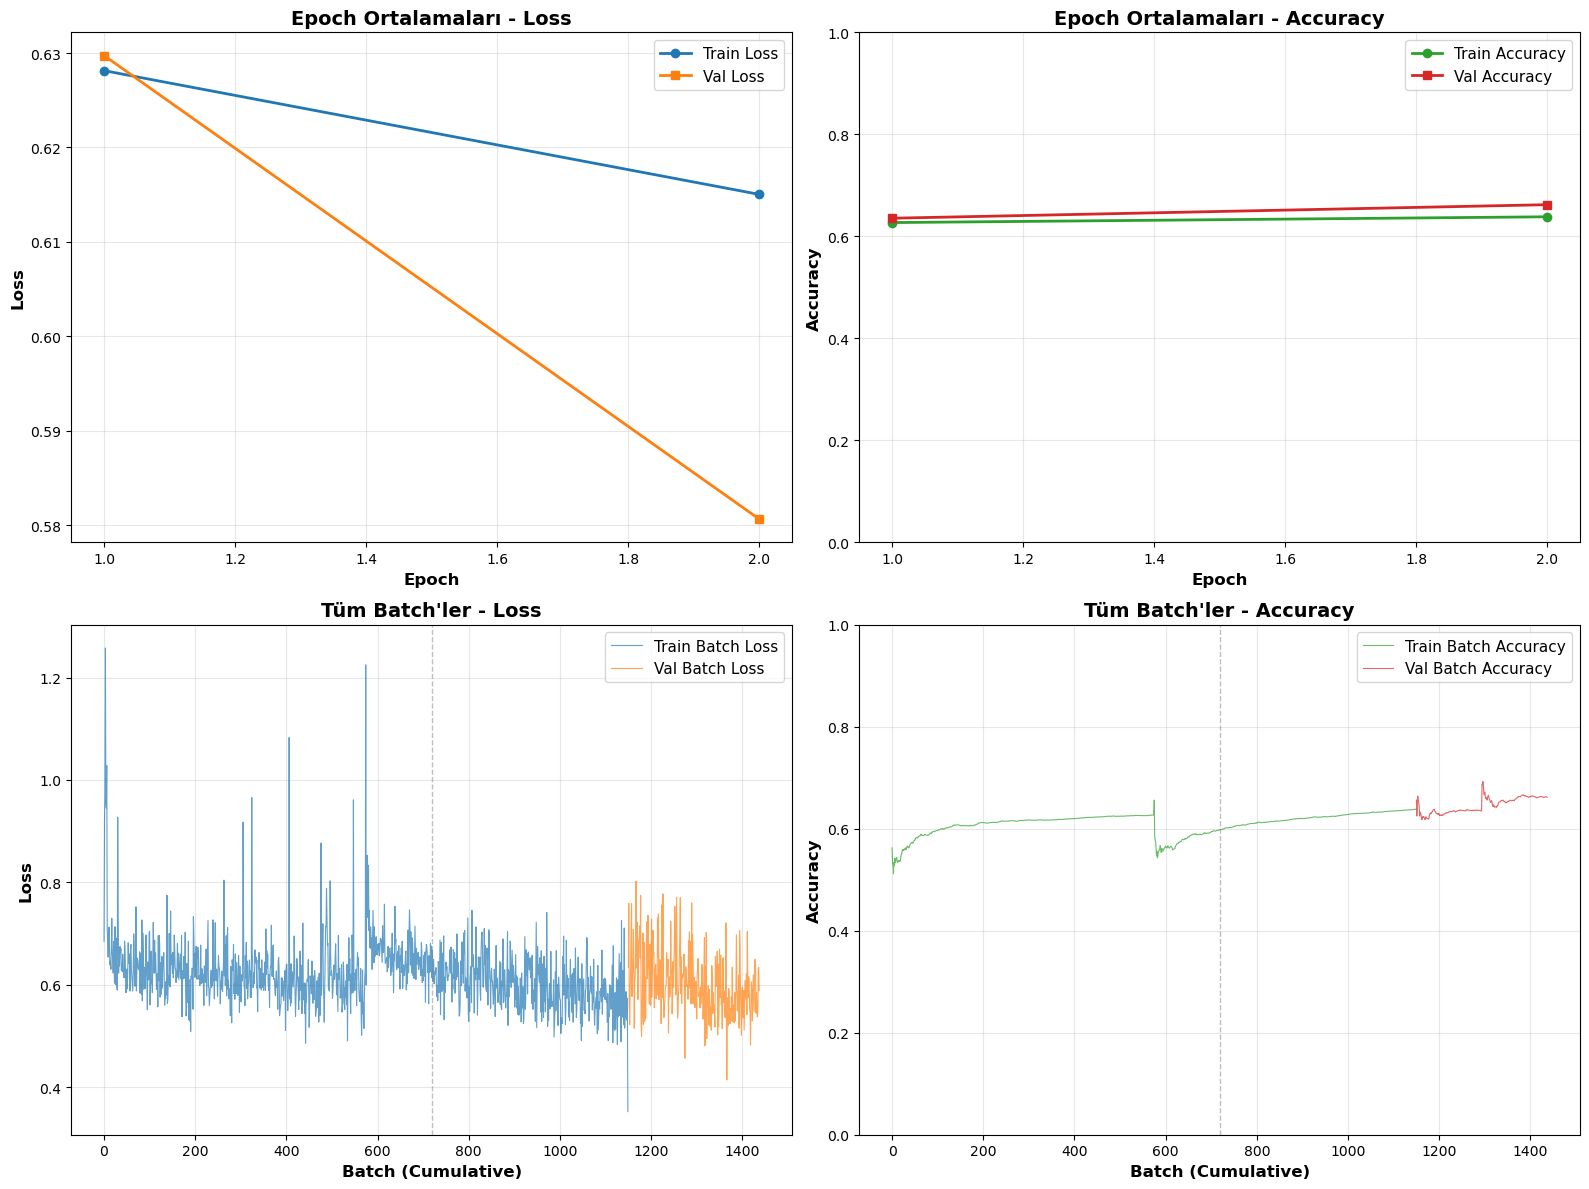

✅ Grafik kaydedildi: eğitim_sonuçları\real_fake_detection\görseller\v1\training_history_epochs.png


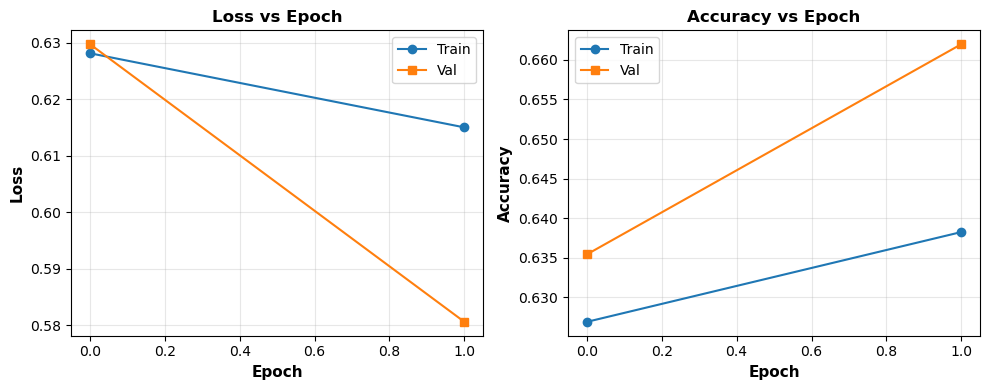

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# ⭐ Batch log'dan DataFrame oluştur
batch_df = pd.DataFrame(batch_log)

# Grafik oluştur (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ==============================================
# 1. Epoch Ortalamaları - Loss
# ==============================================
ax = axes[0, 0]
epochs = range(1, len(history['train']['loss']) + 1)
ax.plot(epochs, history['train']['loss'], marker='o', linewidth=2, label='Train Loss', color='#1f77b4')
ax.plot(epochs, history['val']['loss'], marker='s', linewidth=2, label='Val Loss', color='#ff7f0e')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Epoch Ortalamaları - Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# ==============================================
# 2. Epoch Ortalamaları - Accuracy
# ==============================================
ax = axes[0, 1]
ax.plot(epochs, history['train']['accuracy'], marker='o', linewidth=2, label='Train Accuracy', color='#2ca02c')
ax.plot(epochs, history['val']['accuracy'], marker='s', linewidth=2, label='Val Accuracy', color='#d62728')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Epoch Ortalamaları - Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# ==============================================
# 3. Tüm Batch'ler - Loss
# ==============================================
ax = axes[1, 0]
train_batches = batch_df[batch_df['phase'] == 'train']
val_batches = batch_df[batch_df['phase'] == 'val']

# Batch numaraları oluştur (cumulative)
train_batch_nums = range(len(train_batches))
val_batch_nums = range(len(train_batches), len(train_batches) + len(val_batches))

ax.plot(train_batch_nums, train_batches['loss'].values, linewidth=0.8, alpha=0.7, label='Train Batch Loss', color='#1f77b4')
ax.plot(val_batch_nums, val_batches['loss'].values, linewidth=0.8, alpha=0.7, label='Val Batch Loss', color='#ff7f0e')

# Epoch sınırlarını göster (vertical lines)
total_train_batches = len(train_df[train_df['phase'] == 'train']) if 'train_df' in locals() else len(train_loader)
for i in range(1, len(history['train']['loss'])):
    epoch_end = i * total_train_batches + (i * len(val_loader))
    ax.axvline(x=epoch_end, color='gray', linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Batch (Cumulative)', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Tüm Batch\'ler - Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# ==============================================
# 4. Tüm Batch'ler - Accuracy
# ==============================================
ax = axes[1, 1]
ax.plot(train_batch_nums, train_batches['accuracy'].values, linewidth=0.8, alpha=0.7, label='Train Batch Accuracy', color='#2ca02c')
ax.plot(val_batch_nums, val_batches['accuracy'].values, linewidth=0.8, alpha=0.7, label='Val Batch Accuracy', color='#d62728')

# Epoch sınırlarını göster
for i in range(1, len(history['train']['loss'])):
    epoch_end = i * total_train_batches + (i * len(val_loader))
    ax.axvline(x=epoch_end, color='gray', linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Batch (Cumulative)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Tüm Batch\'ler - Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(version_plots_dir, 'training_history_detailed.png'), dpi=150, bbox_inches='tight')
print(f"✅ Detaylı grafik kaydedildi: {os.path.join(version_plots_dir, 'training_history_detailed.png')}")
plt.show()

# ==============================================
# Basit Epoch Grafikleri (opsiyonel - eski grafik)
# ==============================================
plot_training_history(
    history,
    metrics=['loss', 'accuracy'],
    save_path=os.path.join(version_plots_dir, 'training_history_epochs.png')
)

## 6️⃣ Değerlendirme

In [26]:
from tqdm.notebook import tqdm

all_preds = []
all_labels = []

model.eval()

pbar = tqdm(val_loader, desc="Değerlendirme", leave=True, dynamic_ncols=True)
with torch.no_grad():
    for images, labels in pbar:
        if images is None:
            continue
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        
        # Progress bar güncelle
        pbar.set_postfix({'Tahmini yapılan': len(all_preds)})
        pbar.refresh()

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
print(f"\n✅ Tahminler: {len(all_preds)} örnek")

✅ Tahminler: 9186 örnek


## 7️⃣ Metrikleri Kaydet

In [27]:
metrics = calculate_metrics(all_labels, all_preds, CLASS_NAMES)
export_metrics_to_csv(metrics, CLASS_NAMES, version_data_dir)
print(f"\n✅ Metrikleri kaydedildi ({version_data_dir}/)")
print(f"   Accuracy: {metrics['accuracy']:.2%}")


✅ CSV dosyaları kaydedildi (eğitim_sonuçları\real_fake_detection\veriler\v1/):
   • confusion_matrix_counts.csv
   • confusion_matrix_percentages.csv
   • classification_report.csv
   • summary.csv

✅ Metrikleri kaydedildi (eğitim_sonuçları\real_fake_detection\veriler\v1/)
   Accuracy: 66.20%


## 8️⃣ Confusion Matrix

✅ Grafik kaydedildi: eğitim_sonuçları\real_fake_detection\görseller\v1\confusion_matrix.png


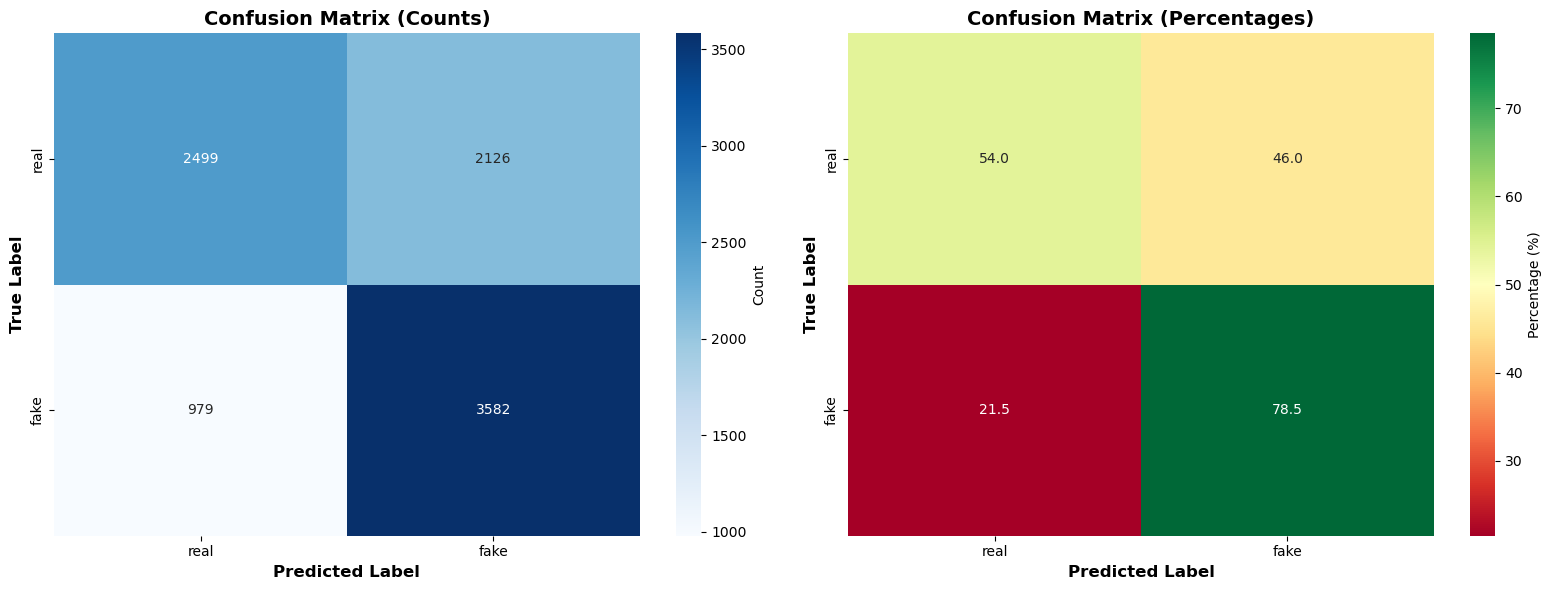

In [28]:
plot_confusion_matrix(
    metrics['cm'],
    CLASS_NAMES,
    save_path=os.path.join(version_plots_dir, 'confusion_matrix.png')
)

## 9️⃣ Analiz

In [29]:
print("\n" + "="*70)
print("📊 ANALİZ")
print("="*70)

cm = metrics['cm']
report = metrics['report']

print(f"\n{'Sınıf':<15} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
print("-"*70)
for class_name in CLASS_NAMES:
    p = report[class_name]['precision']
    r = report[class_name]['recall']
    f1 = report[class_name]['f1-score']
    print(f"{class_name:<15} {p:>11.2%} {r:>12.2%} {f1:>12.2%}")

print(f"\n🔀 Karışıklık:")
print(f"   Real→Fake: {cm[0, 1]}")
print(f"   Fake→Real: {cm[1, 0]}")


📊 ANALİZ

Sınıf              Precision       Recall     F1-Score
----------------------------------------------------------------------
real                 71.85%       54.03%       61.68%
fake                 62.75%       78.54%       69.76%

🔀 Karışıklık:
   Real→Fake: 2126
   Fake→Real: 979
